## <center> Assignment 4. Sarcasm detection with logistic regression
    
We'll be using the dataset from the [paper](https://arxiv.org/abs/1704.05579) "A Large Self-Annotated Corpus for Sarcasm" with >1mln comments from Reddit, labeled as either sarcastic or not. A processed version can be found on Kaggle in a form of a [Kaggle Dataset](https://www.kaggle.com/danofer/sarcasm).

Sarcasm detection is easy. 

<img src="https://habrastorage.org/webt/1f/0d/ta/1f0dtavsd14ncf17gbsy1cvoga4.jpeg" />

# Detección de sarcasmo
Para este ejercicio vas a utilizar el dataset del paper [A Large Self-Annotated Corpus for Sarcasm](https://arxiv.org/abs/1704.05579), con un millón de comentarios de Reddit, etiquetados como sarcásticos o no sarcásticos. Se pide:
1. Si hubiese missings, eliminalos


In [5]:
import sklearn
print(sklearn.__version__)

1.4.1.post1


In [4]:
# some necessary imports
import os
import re
import numpy as np
import pandas as pd
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import accuracy_score, confusion_matrix
import seaborn as sns
from matplotlib import pyplot as plt

from nltk.corpus import stopwords
from nltk.stem.snowball import SnowballStemmer
import eli5

ImportError: cannot import name 'if_delegate_has_method' from 'sklearn.utils.metaestimators' (c:\Users\laura\OneDrive\Desktop\DS_PT_09_2023\.venv\Lib\site-packages\sklearn\utils\metaestimators.py)

|Columna| Descripción | 
|---|----|
|label| TARGET| 
|comment| comentario | 
|author| Autor del comentario| 
|subreddit| subreddit original| 
|score| puntuacion del comentario | 
|ups| nº de votos positivos| 
|downs| nº de votos negativos| 
|date| Día del registro| 
|created_utc| Created datetime| 
|parent_comment| Si comenta en un hilo, hilo al que pertenece| 

In [63]:
df = pd.read_csv('Prof/train-balanced-sarcasm.csv')
df.head()

,label,comment,author,subreddit,score,ups,downs,date,created_utc,parent_comment
0,0,NC and NH.,Trumpbart,politics,2,-1,-1,2016-10,2016-10-16 23:55:23,"Yeah, I get that argument. At this point, I'd ..."
1,0,You do know west teams play against west teams...,Shbshb906,nba,-4,-1,-1,2016-11,2016-11-01 00:24:10,The blazers and Mavericks (The wests 5 and 6 s...
2,0,"They were underdogs earlier today, but since G...",Creepeth,nfl,3,3,0,2016-09,2016-09-22 21:45:37,They're favored to win.
3,0,"This meme isn't funny none of the ""new york ni...",icebrotha,BlackPeopleTwitter,-8,-1,-1,2016-10,2016-10-18 21:03:47,deadass don't kill my buzz
4,0,I could use one of those tools.,cush2push,MaddenUltimateTeam,6,-1,-1,2016-12,2016-12-30 17:00:13,Yep can confirm I saw the tool they use for th...


In [7]:
def explore_data(df):
    print('Data Set Shape:',df.shape)
    print('-------'*100)
    print('Data Columns list:',df.columns)
    print('-------'*100)
    print(df.isna().sum())
    print('-------'*100)
    df.info()

In [8]:
explore_data(df)

Data Set Shape: (1010826, 10)
----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Data Columns list: Index(['label', 'comment', 'author', 'subreddit', 'score', 'ups', 'downs',
       'date', 'created_utc', 'parent_comment'],
      dtype='object')
--------------------------------------------------------------------------------------------------------

In [21]:
print(df.duplicated().value_counts())
print(df.duplicated().sum())
df[df.duplicated()].sort_values(by='author')


False    1010743
True          28
Name: count, dtype: int64
28


,label,comment,author,subreddit,score,ups,downs,date,created_utc,parent_comment
482126,1,Then you attach a video link to their friends ...,CatWizard,PS4,2,2,0,2016-04,2016-04-10 03:54:08,what if the person who owned the account was a...
438766,1,*Sigh* What is this the fifth Italian bread po...,CrimzonGryphon,AskReddit,2,2,0,2015-11,2015-11-09 15:14:20,"Italian bread bakers of Reddit, what's the str..."
652354,1,"What, these people are only improving race rel...",Flakester,news,1,1,0,2015-08,2015-08-11 19:47:33,How to get people to despise and hate you 101.
78313,1,"USE REAL WORDS, DAMN IT",FlameSpartan,TumblrInAction,1,1,0,2016-09,2016-09-07 00:31:39,"Yo, that's such a kawai'i level of desu, it ma..."
201633,1,"Because Sandy Hook, CT and Aurora, CO were so ...",Gogomelo,news,-9,-9,0,2016-07,2016-07-31 11:59:53,"Just stay out of ghetto neighborhoods, violent..."
300841,1,What if the velocity of the electricity is pro...,GoldenScarab569,AskReddit,1,1,0,2016-06,2016-06-30 15:10:20,Electricity takes 1/143 of a second to travel ...
223116,1,That's just a player who knows how to get maxi...,Ignitus1,heroesofthestorm,1,1,0,2016-08,2016-08-06 19:40:18,tell that to the murky I played with yesterday...
434533,1,"""So I went as sheik's dad.. link"" FTFY",JacobTheButtonMasher,zelda,0,0,0,2016-04,2016-04-08 05:34:23,My daughters choice for Halloween last year. Z...
490289,1,"""So I went as sheik's dad.. link"" FTFY",JacobTheButtonMasher,zelda,0,0,0,2016-04,2016-04-08 05:34:23,My daughters choice for Halloween last year. Z...
500972,1,"""So I went as sheik's dad.. link"" FTFY",JacobTheButtonMasher,zelda,1,1,0,2016-04,2016-04-08 05:34:23,My daughters choice for Halloween last year. Z...


In [64]:
df= df.drop_duplicates()

In [65]:
df.dropna(inplace=True)

In [66]:
df.to_csv('Prof/df_sarcasm.csv', index=False)

## EDA ##

In [67]:
X, y = df.drop(columns='label'), df['label']

In [68]:
X.drop(columns=['author','date','created_utc'],inplace=True)

c:\Users\laura\OneDrive\Desktop\DS_PT_09_2023\.venv\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
c:\Users\laura\OneDrive\Desktop\DS_PT_09_2023\.venv\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
c:\Users\laura\OneDrive\Desktop\DS_PT_09_2023\.venv\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):


Text(0.5, 1.0, 'Sarcasm vs. Non-Sarcasm')

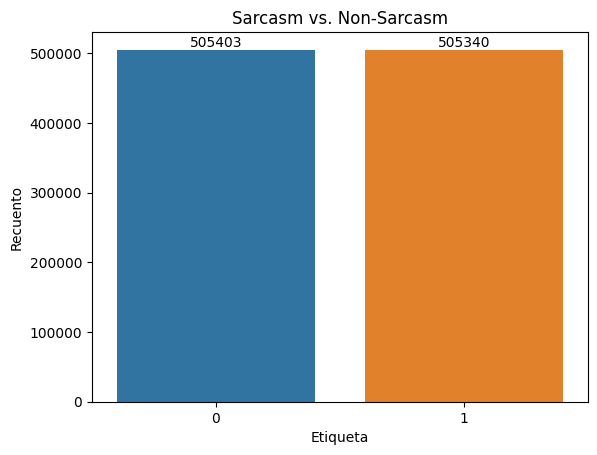

In [43]:
sns.countplot(x='label', data=df)

# Obtener el recuento de cada label
conteo_labels = df['label'].value_counts()

# Agregar texto con los recuentos en el gráfico
for i, conteo in enumerate(conteo_labels):
    plt.text(i, conteo, str(conteo), ha='center', va='bottom')

# Añadir etiquetas y título
plt.xlabel('Etiqueta')
plt.ylabel('Recuento')
plt.title('Sarcasm vs. Non-Sarcasm')


In [35]:
count = pd.DataFrame(y.value_counts())
count

,count
label,
0,505403
1,505340


In [48]:
pd.DataFrame(df['subreddit'].unique())

,0
0,politics
1,nba
2,nfl
3,BlackPeopleTwitter
4,MaddenUltimateTeam
...,...
14871,bestof2010
14872,DallasMeetups
14873,PigJargon
14874,Learnmusic


**Limpieza**

In [69]:

signos = re.compile("(\.)|(\;)|(\:)|(\!)|(\?)|(\¿)|(\@)|(\,)|(\")|(\()|(\))|(\[)|(\])|(\d+)")
# eliminamos todo lo que nos estorba, con regex

def signs_to_del(text):
    return signos.sub('', text.lower())

cols_to_edit = ['comment', 'parent_comment']

for i in X[cols_to_edit]:
    X[i] = X[i].apply(signs_to_del)

In [70]:
def remove_links(df):
    return " ".join(['{link}' if ('http') in word else word for word in df.split()])


for i in X[cols_to_edit]:
    X[i] = X[i].apply(signs_to_del)

In [74]:
X.head()

,comment,subreddit,score,ups,downs,parent_comment
0,nc nh,politics,2,-1,-1,yeah get argument point i'd prefer lived nc well
1,know west teams play west teams east teams right,nba,-4,-1,-1,blazers mavericks wests seed even carry good e...
2,underdogs earlier today since gronk's announce...,nfl,3,3,0,they're favored win
3,meme funny none new york nigga ones,BlackPeopleTwitter,-8,-1,-1,deadass kill buzz
4,could use one tools,MaddenUltimateTeam,6,-1,-1,yep confirm saw tool use made boy easports_mut


### MODELO ###

In [72]:
def remove_stopwords(df):
    english_stopwords = stopwords.words('english')
    return " ".join([word for word in df.split() if word not in english_stopwords])

In [73]:
for i in X[cols_to_edit]:
    X[i] = X[i].apply(remove_stopwords)

In [81]:

tfidf_vect = TfidfVectorizer(ngram_range=(1, 2))
log_reg = LogisticRegression()


pipeline = Pipeline([
    ('tfidf', tfidf_vect),
    ('logistic', log_reg)
])

parameters = {
    'tfidf__max_df': (0.5, 1 , 1.9),
    'tfidf__min_df': (5, 10, 20,50),
    "logistic__penalty": ["l1","l2"], # Regularizaciones L1 y L2.
    "logistic__C": [0.1, 0.5, 1.0, 5.0] # Cuanta regularizacion queremos

}

grid_search = GridSearchCV(pipeline,
                          parameters,
                          cv = 5,
                          n_jobs = -1,
                          scoring = 'accuracy', 
                          verbose = 1)


grid_search.fit(X, y)
print("Best params:", grid_search.best_params_)
print("Best acc:", grid_search.best_score_)
print("Best model:", grid_search.best_estimator_)


KeyboardInterrupt: 

**Guardar Modelo**

In [ ]:
import pickle

with open('Machine_Learning/6-NLP/NLTK&CountVectorizer/ejercicios/Prof/finished_model.model', "wb") as archivo_salida:  #tambien se puede guardar en pkl  en lugar de .model
    pickle.dump(grid_search.best_estimator_, archivo_salida)

**Predicciones**

In [ ]:
# Step 6: Evaluate the model
predictions = grid_search.predict(test_texts)
print(classification_report(test_labels, predictions))

## Tasks:
1. Analyze the dataset, make some plots. This [Kernel](https://www.kaggle.com/sudalairajkumar/simple-exploration-notebook-qiqc) might serve as an example
2. Build a Tf-Idf + logistic regression pipeline to predict sarcasm (`label`) based on the text of a comment on Reddit (`comment`).
3. Plot the words/bigrams which a most predictive of sarcasm (you can use [eli5](https://github.com/TeamHG-Memex/eli5) for that)
4. (optionally) add subreddits as new features to improve model performance. Apply here the Bag of Words approach, i.e. treat each subreddit as a new feature.

## Links:
  - Machine learning library [Scikit-learn](https://scikit-learn.org/stable/index.html) (a.k.a. sklearn)
  - Kernels on [logistic regression](https://www.kaggle.com/kashnitsky/topic-4-linear-models-part-2-classification) and its applications to [text classification](https://www.kaggle.com/kashnitsky/topic-4-linear-models-part-4-more-of-logit), also a [Kernel](https://www.kaggle.com/kashnitsky/topic-6-feature-engineering-and-feature-selection) on feature engineering and feature selection
  - [Kaggle Kernel](https://www.kaggle.com/abhishek/approaching-almost-any-nlp-problem-on-kaggle) "Approaching (Almost) Any NLP Problem on Kaggle"
  - [ELI5](https://github.com/TeamHG-Memex/eli5) to explain model predictions